# Libraries for Model Training

In [ ]:
import tensorflow as tf
from sklearn.metrics import f1_score
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from keras.models import Sequential,model_from_json
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Dropout, Conv2D
import tensorflow.keras.backend as K


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Training and Validation Data Processing

In [ ]:

train_datagen = ImageDataGenerator(rescale=1./255, width_shift_range=0.1, height_shift_range=0.1)
path = '/content/drive/MyDrive'
train_generator = train_datagen.flow_from_directory(
        path+'/training_data',  # this is the target directory
        target_size=(28,28),  # all images will be resized to 28x28
        batch_size=1,
        class_mode='sparse')

validation_generator = train_datagen.flow_from_directory(
        path+'/val_data',  # this is the target directory
        target_size=(28,28),  # all images will be resized to 28x28 batch_size=1,
        class_mode='sparse')

Found 1292 images belonging to 17 classes.
Found 429 images belonging to 17 classes.


# Took These F1-Score from my other projects

In [ ]:
def f1score(y, y_pred):
    return f1_score(y, tf.math.argmax(y_pred, axis=1), average='micro')

def custom_f1score(y, y_pred):
    return tf.py_function(f1score, (y, y_pred), tf.double)

### Took these too from my other project. It is to save and load a pretrained model. So, that we don't have to re train the model again and again

In [ ]:
def store_keras_model(model, model_name):
    model_json = model.to_json() # serialize model to JSON
    with open("./{}.json".format(model_name), "w") as json_file:
        json_file.write(model_json)
    model.save_weights("./{}.h5".format(model_name)) # serialize weights to HDF5
    print("Saved model to disk")

def load_keras_model(model_name):
    # Load json and create model
    json_file = open('./{}.json'.format(model_name), 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    # Load weights into new model
    model.load_weights("./{}.h5".format(model_name))
    return model

# Model for Training

In [ ]:
K.clear_session()
model = Sequential()
model.add(Conv2D(16, (22,22), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (16,16), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (8,8), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (4,4), input_shape=(28, 28, 3), activation='relu', padding='same'))

model.add(MaxPooling2D(pool_size=(4,4)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(128, activation='relu'))
model.add(Dense(17, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=0.0001), metrics=[custom_f1score])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        23248     
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        131104    
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        131136    
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 128)       131200    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 7, 7, 128)        0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                        

# Making a Condition for Ending the Training Quickly once the required accuracy is achieved

In [ ]:
class stop_training_callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_custom_f1score') > 1.99):
              self.model.stop_training = True

# Training

In [ ]:
batch_size = 1
callbacks = [stop_training_callback()]
model.fit(
      train_generator,
      steps_per_epoch = train_generator.samples // batch_size,
      validation_data = validation_generator,
      epochs = 40, verbose=1, callbacks=callbacks)

Epoch 1/40
1292/1292 [==============================] - 23s 15ms/step - loss: 2.6992 - custom_f1score: 0.0944 - val_loss: 2.6970 - val_custom_f1score: 0.0859
Epoch 2/40
1292/1292 [==============================] - 17s 13ms/step - loss: 2.5831 - custom_f1score: 0.1347 - val_loss: 2.4839 - val_custom_f1score: 0.1794
Epoch 3/40
1292/1292 [==============================] - 16s 12ms/step - loss: 1.8751 - custom_f1score: 0.4079 - val_loss: 1.5027 - val_custom_f1score: 0.5273
Epoch 4/40
1292/1292 [==============================] - 16s 12ms/step - loss: 1.2982 - custom_f1score: 0.5967 - val_loss: 0.9223 - val_custom_f1score: 0.7325
Epoch 5/40
1292/1292 [==============================] - 16s 12ms/step - loss: 0.8638 - custom_f1score: 0.7407 - val_loss: 0.7110 - val_custom_f1score: 0.8027
Epoch 6/40
1292/1292 [==============================] - 15s 12ms/step - loss: 0.7113 - custom_f1score: 0.7833 - val_loss: 0.5812 - val_custom_f1score: 0.8249
Epoch 7/40
1292/1292 [==============================

# Storing the Model, we just trained


In [ ]:
store_keras_model(model, 'model_LicensePlate')

Saved model to disk


## Loading the Pre-Trained Model(remove the Comments and run it)

In [ ]:
pre_trained_model = load_keras_model('model_LicensePlate')
model = pre_trained_model

### Checking if the model is the same

In [ ]:
def fix_dimension(img):
    new_img = np.zeros((28,28,3))
    for i in range(3):
        new_img[:,:,i] = img
    return new_img

def show_results():
    dic = {}
    characters = ['0','1','2','3','4','5','6','7','8','9','Dhaka','Jha','Matro','ka','ga','La']
    for i,c in enumerate(characters):
        dic[i] = c

    output = []
    for i,ch in enumerate(char): #iterating over the characters
        img_ = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
        img = fix_dimension(img_)
        img = img.reshape(1,28,28,3) #preparing image for the model
       # y_ = model.predict_classes(img)[0] #predicting the class
       # y_ = (model.predict(img)[0] > 0.5).astype("int32")
        predict_x=model.predict(img)[0]
        classes_x=np.argmax(predict_x,axis=0)
        y_=classes_x
        #print('wwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwww')
        print(y_)
        character = dic[int(y_)] #
        output.append(character) #storing the result in a list

    plate_number = ''.join(map(str, output))
    return plate_number

a=show_results()
print(a)




1/1 [==============================] - 0s 96ms/step
6
1/1 [==============================] - 0s 23ms/step
12
1/1 [==============================] - 0s 21ms/step
5
1/1 [==============================] - 0s 21ms/step
12
1/1 [==============================] - 0s 23ms/step
12
1/1 [==============================] - 0s 19ms/step
3
1/1 [==============================] - 0s 27ms/step
9
1/1 [==============================] - 0s 23ms/step
12
1/1 [==============================] - 0s 21ms/step
9
1/1 [==============================] - 0s 19ms/step
4
1/1 [==============================] - 0s 21ms/step
13
1/1 [==============================] - 0s 25ms/step
7
1/1 [==============================] - 0s 27ms/step
3
1/1 [==============================] - 0s 26ms/step
11
1/1 [==============================] - 0s 28ms/step
7
6Matro5MatroMatro39Matro94ka73Jha7


In [ ]:
from difflib import SequenceMatcher

In [ ]:
def similar(a,b):
  return SequenceMatcher(None, a.lower(), b.lower()).ratio()

In [ ]:
true_value = "9dhaka94matro773jha7"
predicted_value = a[4:]
print(similar(true_value,predicted_value))

0.9523809523809523


In [ ]:
scores = [0.950,0.867,0.8372,0.8125,0.909,0.857,0.973,0.878,0.814,0.858]
scores=(sum(scores) / 10) * 100
scores

87.557

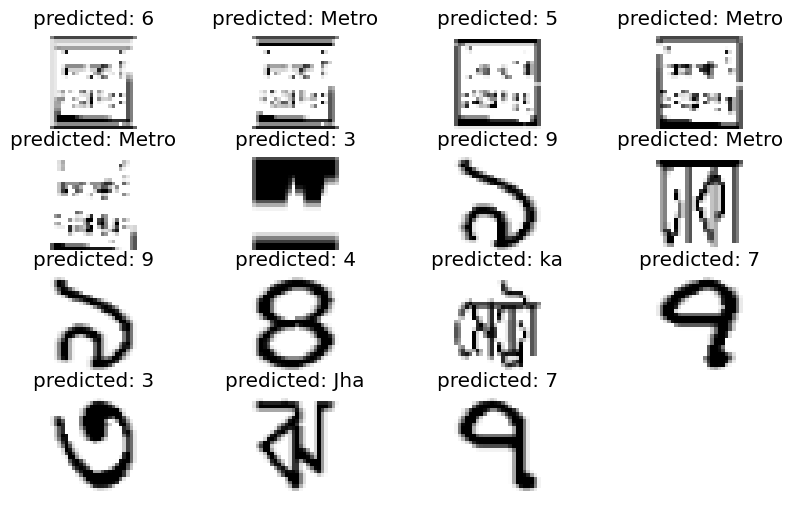

In [ ]:
# Segmented characters and their predicted value.
plt.figure(figsize=(10,6))
i=0
for j,ch in enumerate(char):

    img = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
    plt.subplot(4,4,j+1)
    plt.imshow(img,cmap='gray')
    if a[i]=='D':
      x='Dhaka'
      i=i+5
    elif a[i]=='M':
      x='Metro'
      i=i+5
    elif a[i]=='J':
      x='Jha'
      i=i+3
    elif a[i]=='k':
      x='ka'
      i=i+2

    elif a[i]=='g':
      x='ga'
      i=i+2

    elif a[i]=='L':
      x='La'
      i=i+2

    elif a[i]=='N':
      x='Narayanganj'
      i=i+10

    else:
      x=a[i]
      i=i+1
    title_obj = plt.title(f'predicted: {x}')
    plt.setp(title_obj, color='black')
    plt.axis('off')
plt.show()

In [ ]:
print(pre_trained_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        23248     
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        131104    
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        131136    
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 128)       131200    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 7, 7, 128)        0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                        

Testing the model on the validation dataset because a seperate dataset for testing is not available.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import cv2
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping


In [ ]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : class_0
1 : class_1
2 : class_2
3 : class_3
4 : class_4
5 : class_5
6 : class_6
7 : class_7
8 : class_8
9 : class_9
10 : class_DHAKA
11 : class_JHA
12 : class_LA
13 : class_MATRO
14 : class_NARAYANGANJ
15 : class_ga
16 : class_k


In [ ]:
#fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 12))
#idx = 0

#for i in range(2):
 #   for j in range(5):
  #      label = labels[np.argmax(train_generator[0][0][idx])]
   #     ax[i, j].set_title(f"{label}")
    #    ax[i, j].imshow(train_generator[0][0][idx][:, :, :])
     #   ax[i, j].axis("off")
      #  idx += 1

#plt.tight_layout()
#plt.suptitle("Sample Training Images", fontsize=21)
#plt.show()

In [ ]:
test_dataset = '/content/drive/MyDrive/testing_data'

In [ ]:
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(test_dataset,
                                                 shuffle=False,
                                                 batch_size=1,
                                                 target_size = (28,28),
                                                 class_mode='categorical')

Found 303 images belonging to 17 classes.


### **7. Model Prediction on the Test Dataset**

In [ ]:
predictions = model.predict(test_generator)

303/303 [==============================] - 6s 20ms/step


In [ ]:
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001), loss=CategoricalCrossentropy(), metrics=['accuracy'])

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator, batch_size=1)

303/303 [==============================] - 3s 8ms/step - loss: 0.3338 - accuracy: 0.9340


In [ ]:
print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Test Loss:     0.3337598443031311
Test Accuracy: 0.933993399143219


### **8. Plotting the Classification Metrics**

### **i. Confusion Matrix**

In [ ]:
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

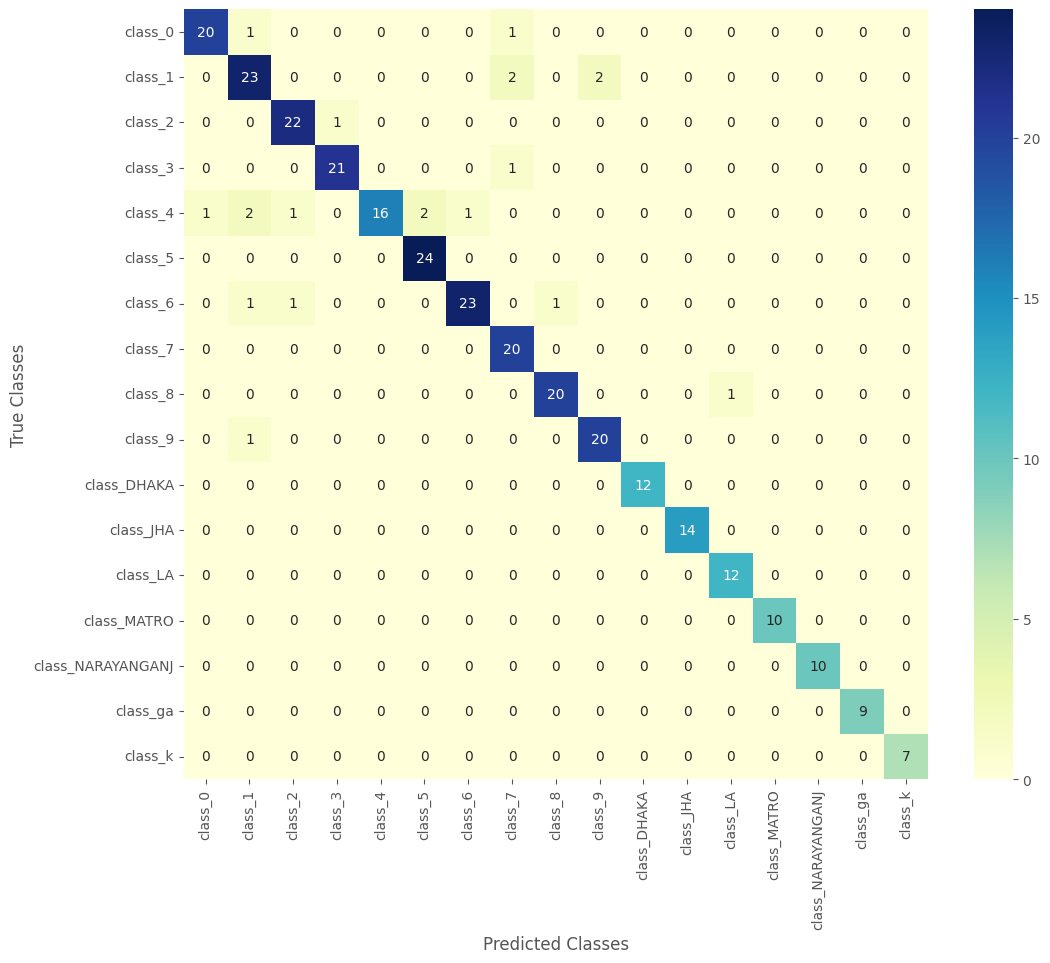

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

cf_mtx = confusion_matrix(y_true, y_pred)

group_counts = ["{0:0.0f}".format(value) for value in cf_mtx.flatten()]
box_labels = np.asarray(group_counts).reshape(cf_mtx.shape[0], cf_mtx.shape[1])

plt.figure(figsize=(12, 10))
sns.heatmap(cf_mtx, xticklabels=labels.values(), yticklabels=labels.values(),
            cmap="YlGnBu", fmt="", annot=box_labels)
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.show()


In [ ]:
print(classification_report(y_true, y_pred, target_names=labels.values()))

                   precision    recall  f1-score   support

          class_0       0.95      0.91      0.93        22
          class_1       0.82      0.85      0.84        27
          class_2       0.92      0.96      0.94        23
          class_3       0.95      0.95      0.95        22
          class_4       1.00      0.70      0.82        23
          class_5       0.92      1.00      0.96        24
          class_6       0.96      0.88      0.92        26
          class_7       0.83      1.00      0.91        20
          class_8       0.95      0.95      0.95        21
          class_9       0.91      0.95      0.93        21
      class_DHAKA       1.00      1.00      1.00        12
        class_JHA       1.00      1.00      1.00        14
         class_LA       0.92      1.00      0.96        12
      class_MATRO       1.00      1.00      1.00        10
class_NARAYANGANJ       1.00      1.00      1.00        10
         class_ga       1.00      1.00      1.00       